## Crude Oil Risk Model

[*********************100%***********************]  2 of 2 completed


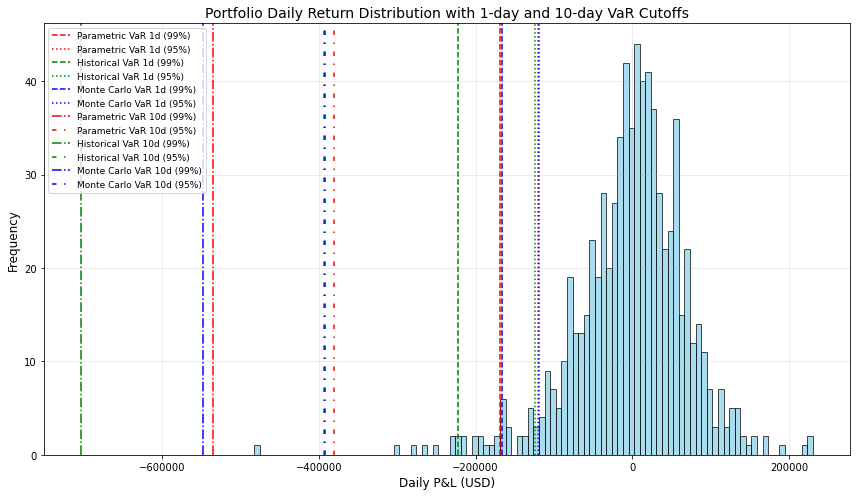

=== VaR Summary ===
1-day Parametric VaR (99%): $169,453.25
10-day Parametric VaR (99%): $535,858.24
1-day Parametric VaR (95%): $120,469.41
10-day Parametric VaR (95%): $380,957.71
1-day Historical VaR (99%): $222,749.65
10-day Historical VaR (99%): $704,396.26
1-day Historical VaR (95%): $124,663.92
10-day Historical VaR (95%): $394,221.92

=== Monte Carlo VaR ===
1-day Monte Carlo VaR (99%): $166,547.21
10-day Monte Carlo VaR (99%): $547,596.78
1-day Monte Carlo VaR (95%): $119,080.37
10-day Monte Carlo VaR (95%): $392,526.70

=== Stress Test Results ===
  Shock (%)  Brent P&L (USD)  WTI P&L (USD)  Total Portfolio P&L (USD)
0      -10%       -676100.01      325550.00                 -350550.00
1      -15%      -1014150.01      488325.00                 -525825.00
2      -20%      -1352200.01      651100.01                 -701100.01


In [15]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm

# Define parameters
symbols = ["BZ=F", "CL=F"]
start_date = "2022-07-01"
end_date = "2025-07-01"

# Download data
raw_data = yf.download(symbols, start=start_date, end=end_date, auto_adjust=False)

# Handle multi-index or flat structure
if isinstance(raw_data.columns, pd.MultiIndex):
    data = raw_data['Adj Close'].copy()
    data.columns = ['Brent', 'WTI']
else:
    data = raw_data[['BZ=F', 'CL=F']].copy()
    data.columns = ['Brent', 'WTI']

# Compute log returns
returns = np.log(data / data.shift(1)).dropna()

# Position assumptions
brent_contracts = 100
wti_contracts = -50
contract_size = 1000

# Notional exposure
brent_price = data['Brent'].iloc[-1]
wti_price = data['WTI'].iloc[-1]
brent_notional = brent_contracts * contract_size * brent_price
wti_notional = wti_contracts * contract_size * wti_price

# Daily portfolio returns in USD
portfolio_returns = (
    returns['Brent'] * brent_notional +
    returns['WTI'] * wti_notional
)

# Parametric VaR (99%)
mean_ret = portfolio_returns.mean()
std_ret = portfolio_returns.std()
z_99 = norm.ppf(0.01)
param_var_1d = -(mean_ret + z_99 * std_ret)
param_var_10d = np.sqrt(10) * param_var_1d

# Parametric VaR (95%)
z_95 = norm.ppf(0.05)
param_var_1d_95 = -(mean_ret + z_95 * std_ret)
param_var_10d_95 = np.sqrt(10) * param_var_1d_95

# Historical VaR (99%)
hist_var_1d_99 = -np.percentile(portfolio_returns, 1)
hist_var_10d_99 = np.sqrt(10) * hist_var_1d_99

# Historical VaR (95%)
hist_var_1d_95 = -np.percentile(portfolio_returns, 5)
hist_var_10d_95 = np.sqrt(10) * hist_var_1d_95

# Monte Carlo Simulation Parameters
n_simulations = 10000
simulated_returns = np.random.normal(mean_ret, std_ret, n_simulations)

# Simulate 1-day P&L from portfolio
simulated_pnl = simulated_returns

# Monte Carlo VaR (99%)
mc_var_1d_99 = -np.percentile(simulated_pnl, 1)
mc_var_1d_95 = -np.percentile(simulated_pnl, 5)

# 10-day (by scaling standard deviation)
simulated_10d_returns = np.random.normal(mean_ret * 10, std_ret * np.sqrt(10), n_simulations)
mc_var_10d_99 = -np.percentile(simulated_10d_returns, 1)
mc_var_10d_95 = -np.percentile(simulated_10d_returns, 5)

# Plot histogram of daily portfolio returns
plt.figure(figsize=(12, 7))
plt.hist(portfolio_returns, bins=100, color='skyblue', edgecolor='black', alpha=0.7)

# === 1-day VaRs ===
plt.axvline(-param_var_1d, color='red', linestyle='--', label='Parametric VaR 1d (99%)')
plt.axvline(-param_var_1d_95, color='red', linestyle=':', label='Parametric VaR 1d (95%)')

plt.axvline(-hist_var_1d_99, color='green', linestyle='--', label='Historical VaR 1d (99%)')
plt.axvline(-hist_var_1d_95, color='green', linestyle=':', label='Historical VaR 1d (95%)')

plt.axvline(-mc_var_1d_99, color='blue', linestyle='--', label='Monte Carlo VaR 1d (99%)')
plt.axvline(-mc_var_1d_95, color='blue', linestyle=':', label='Monte Carlo VaR 1d (95%)')

# === 10-day VaRs ===
plt.axvline(-param_var_10d, color='red', linestyle='-.', label='Parametric VaR 10d (99%)')
plt.axvline(-param_var_10d_95, color='red', linestyle=(0, (3, 5, 1, 5)), label='Parametric VaR 10d (95%)')

plt.axvline(-hist_var_10d_99, color='green', linestyle='-.', label='Historical VaR 10d (99%)')
plt.axvline(-hist_var_10d_95, color='green', linestyle=(0, (3, 5, 1, 5)), label='Historical VaR 10d (95%)')

plt.axvline(-mc_var_10d_99, color='blue', linestyle='-.', label='Monte Carlo VaR 10d (99%)')
plt.axvline(-mc_var_10d_95, color='blue', linestyle=(0, (3, 5, 1, 5)), label='Monte Carlo VaR 10d (95%)')

# Labels and formatting
plt.title("Portfolio Daily Return Distribution with 1-day and 10-day VaR Cutoffs", fontsize=14)
plt.xlabel("Daily P&L (USD)", fontsize=12)
plt.ylabel("Frequency", fontsize=12)
plt.grid(True, alpha=0.3)
plt.legend(loc='upper left', fontsize=9)
plt.tight_layout()
plt.show()

# Print summary
print("=== VaR Summary ===")
print(f"1-day Parametric VaR (99%): ${param_var_1d:,.2f}")
print(f"10-day Parametric VaR (99%): ${param_var_10d:,.2f}")
print(f"1-day Parametric VaR (95%): ${param_var_1d_95:,.2f}")
print(f"10-day Parametric VaR (95%): ${param_var_10d_95:,.2f}")
print(f"1-day Historical VaR (99%): ${hist_var_1d_99:,.2f}")
print(f"10-day Historical VaR (99%): ${hist_var_10d_99:,.2f}")
print(f"1-day Historical VaR (95%): ${hist_var_1d_95:,.2f}")
print(f"10-day Historical VaR (95%): ${hist_var_10d_95:,.2f}")

# Output
print("\n=== Monte Carlo VaR ===")
print(f"1-day Monte Carlo VaR (99%): ${mc_var_1d_99:,.2f}")
print(f"10-day Monte Carlo VaR (99%): ${mc_var_10d_99:,.2f}")
print(f"1-day Monte Carlo VaR (95%): ${mc_var_1d_95:,.2f}")
print(f"10-day Monte Carlo VaR (95%): ${mc_var_10d_95:,.2f}")

# Stress test simulation
shocks = [-0.10, -0.15, -0.20]
stress_results = []

for shock in shocks:
    pnl_brent = brent_notional * shock
    pnl_wti = wti_notional * shock
    total_pnl = pnl_brent + pnl_wti
    stress_results.append({
        'Shock (%)': f"{int(shock * 100)}%",
        'Brent P&L (USD)': round(pnl_brent, 2),
        'WTI P&L (USD)': round(pnl_wti, 2),
        'Total Portfolio P&L (USD)': round(total_pnl, 2)
    })

stress_df = pd.DataFrame(stress_results)
print("\n=== Stress Test Results ===")
print(stress_df)



